In [ ]:
%pip install import pandas as pd
import numpy seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Total features: 4
Data shape: (1057, 4)

Train: 769, Val: 153, Test: 104



/tmp/ipykernel_159751/4135333565.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')
/home/azani/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 56)         │        13,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 56)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 28)             │         9,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,605 (92.21 KB)

 Trainable params: 23,605 (92.21 KB)

 Non-trainable params: 0 (0.00 B)

🔧 Training model...

Epoch 1/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0144 - mae: 0.0941 - val_loss: 0.0027 - val_mae: 0.0424 - learning_rate: 8.0000e-04
Epoch 2/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - mae: 0.0869 - val_loss: 0.0026 - val_mae: 0.0415 - learning_rate: 8.0000e-04
Epoch 3/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0107 - mae: 0.0822 - val_loss: 0.0024 - val_mae: 0.0406 - learning_rate: 8.0000e-04
Epoch 4/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106 - mae: 0.0813 - val_loss: 0.0027 - val_mae: 0.0423 - learning_rate: 8.0000e-04
Epoch 5/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100 - mae: 0.0792 - val_loss: 0.0025 - val_mae: 0.0408 - learning_rate: 8.0000e-04
Epoch 6/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0092 - mae: 0.0762 - val_loss: 0.0026 - val_mae: 0.0418 - learning_rate: 8.0000e-04
Epoch 7/250
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0083 - mae: 0.0712 - val_loss: 0.0021 - v

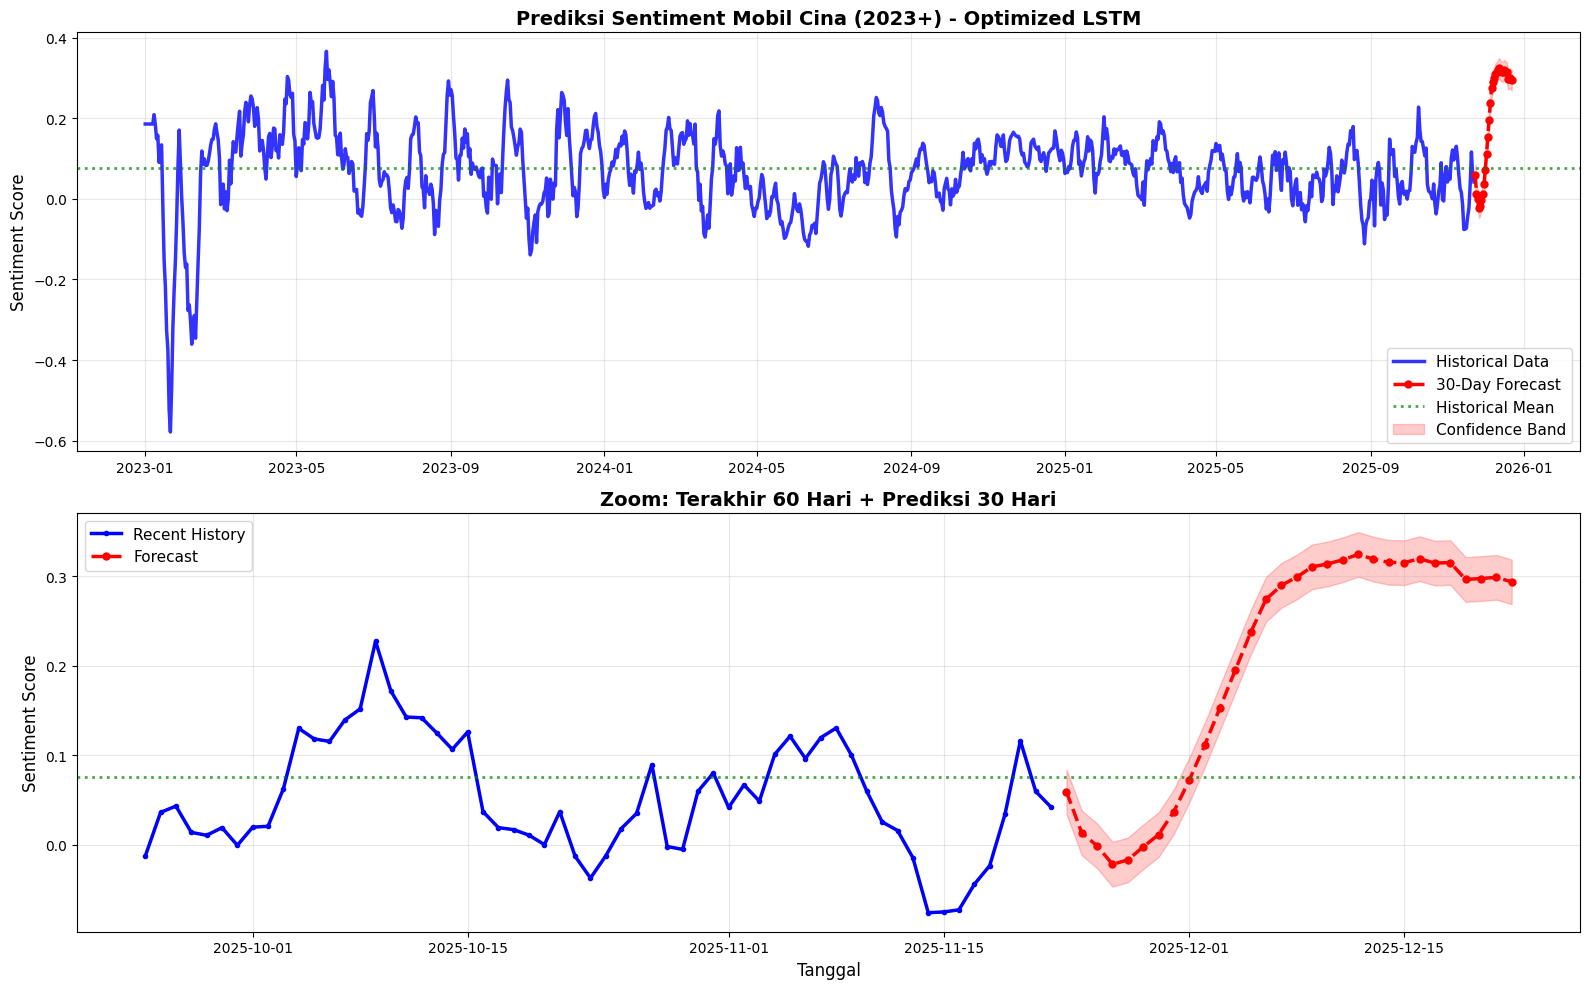


📈 SUMMARY PREDIKSI 30 HARI
Sentiment saat ini:   0.0420
Rata-rata prediksi:   0.2022
Min prediksi:         -0.0219
Max prediksi:         0.3247
Trend:                📈 NAIK (+1083.31%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import random
import tensorflow as tf
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==========================================
# 1. PERSIAPAN DATA
# ==========================================
INPUT_FILE = "data_with_sentiment_score.csv"
df = pd.read_csv(INPUT_FILE)
df['published_at'] = pd.to_datetime(df['published_at']).dt.tz_localize(None)
START_DATE = '2023-01-01'
df_filtered = df[df['published_at'] >= START_DATE].copy()
df_daily = df_filtered.set_index('published_at').resample('D')['sentiment_score'].mean().ffill()

# Smoothing
df_smooth = df_daily.rolling(window=7).mean().fillna(method='bfill')

# ==========================================
# 2. FITUR ENGINEERING (4 FEATURES)
# ==========================================
df_features = pd.DataFrame(index=df_smooth.index)
df_features['smoothed'] = df_smooth
df_features['raw_daily'] = df_daily
df_features['momentum'] = df_smooth.diff().fillna(0)
df_features['volatility'] = df_daily.rolling(window=7).std().fillna(0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features)
n_features = scaled_data.shape[1]

print(f"Total features: {n_features}")
print(f"Data shape: {scaled_data.shape}\n")

# ==========================================
# 3. WINDOWING DATA
# ==========================================
LOOK_BACK = 30

def create_dataset_multi(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X, y = create_dataset_multi(scaled_data, LOOK_BACK)

# Better split: lebih banyak test untuk validasi
train_size = int(len(X) * 0.75)
val_size = int(len(X) * 0.15)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}\n")

# ==========================================
# 4. MODEL - OPTIMIZED (Reduced overfitting)
# ==========================================
from tensorflow.keras.regularizers import l2

# Kita akan menggunakan L2 Regularization dan Dropout yang sedikit lebih tinggi
model = Sequential([
    # Kapasitas agak dikurangi dan L2 Regularization ditambahkan
    LSTM(52, return_sequences=True, input_shape=(LOOK_BACK, n_features), 
         kernel_regularizer=l2(0.0001)), 
    Dropout(0.45),  # Naik sedikit dari 0.4
    
    LSTM(26, return_sequences=False, 
         kernel_regularizer=l2(0.0001)), # Kapasitas turun, L2 ditambahkan
    Dropout(0.45),  # Naik sedikit dari 0.4
    
    Dense(12, activation='relu', 
          kernel_regularizer=l2(0.0001)), # Kapasitas turun, L2 ditambahkan
    Dropout(0.30),  # Naik sedikit dari 0.25
    Dense(1, activation='sigmoid')
])
# Mengubah Learning Rate menjadi lebih kecil untuk konvergensi yang lebih halus
optimizer = Adam(learning_rate=0.0004) # Turun signifikan dari 0.0008
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30, # Naik untuk memberi waktu lebih banyak (Stabilitas)
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001 # Naik agar hanya merespons perbaikan yang signifikan
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15, # Naik untuk stabilitas
        min_lr=0.00005, # Minimum LR lebih rendah untuk eksplorasi halus
        verbose=1
    )]

print("🔧 Training model...\n")
history = model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=32, # Naik dari 16 (Batch besar = lebih stabil, umum)
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1)

# ==========================================
# 5. EVALUASI
# ==========================================
def inverse_transform_predictions(scaler, predictions, y_true, n_features):
    pred_dummy = np.zeros((len(predictions), n_features))
    true_dummy = np.zeros((len(y_true), n_features))
    pred_dummy[:, 0] = predictions.flatten()
    true_dummy[:, 0] = y_true.flatten()
    pred_inv = scaler.inverse_transform(pred_dummy)[:, 0]
    true_inv = scaler.inverse_transform(true_dummy)[:, 0]
    return pred_inv, true_inv

train_predict = model.predict(X_train, verbose=0)
val_predict = model.predict(X_val, verbose=0)
test_predict = model.predict(X_test, verbose=0)

train_predict_inv, y_train_inv = inverse_transform_predictions(scaler, train_predict, y_train, n_features)
val_predict_inv, y_val_inv = inverse_transform_predictions(scaler, val_predict, y_val, n_features)
test_predict_inv, y_test_inv = inverse_transform_predictions(scaler, test_predict, y_test, n_features)

print("\n" + "="*60)
print("📊 METRIK EVALUASI")
print("="*60)

train_mae = mean_absolute_error(y_train_inv, train_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
train_r2 = r2_score(y_train_inv, train_predict_inv)

val_mae = mean_absolute_error(y_val_inv, val_predict_inv)
val_rmse = np.sqrt(mean_squared_error(y_val_inv, val_predict_inv))
val_r2 = r2_score(y_val_inv, val_predict_inv)

test_mae = mean_absolute_error(y_test_inv, test_predict_inv)
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))
test_r2 = r2_score(y_test_inv, test_predict_inv)

print(f"\n--- TRAINING SET ({len(X_train)} samples) ---")
print(f"MAE:  {train_mae:.5f}")
print(f"RMSE: {train_rmse:.5f}")
print(f"R²:   {train_r2:.5f}")

print(f"\n--- VALIDATION SET ({len(X_val)} samples) ---")
print(f"MAE:  {val_mae:.5f}")
print(f"RMSE: {val_rmse:.5f}")
print(f"R²:   {val_r2:.5f}")

print(f"\n--- TEST SET ({len(X_test)} samples) ---")
print(f"MAE:  {test_mae:.5f}")
print(f"RMSE: {test_rmse:.5f}")
print(f"R²:   {test_r2:.5f}")

gap_train_test = train_r2 - test_r2
gap_val_test = val_r2 - test_r2

print(f"\n⚠️  Overfitting Gap (Train - Test): {gap_train_test:.5f}")
print(f"⚠️  Overfitting Gap (Val - Test):   {gap_val_test:.5f}")

if gap_train_test < 0.10:
    print("   ✅ EXCELLENT - Generalization sangat baik")
elif gap_train_test < 0.15:
    print("   ✅ GOOD - Generalization baik")
elif gap_train_test < 0.20:
    print("   ⚠️  ACCEPTABLE - Ada sedikit overfitting")
else:
    print("   ❌ HIGH - Overfitting tinggi")

# ==========================================
# 6. PREDIKSI MASA DEPAN - FLEXIBLE HORIZON
# ==========================================
print("\n" + "="*60)
print("🔮 PREDIKSI MASA DEPAN")
print("="*60 + "\n")

# PILIH SALAH SATU:
DAYS_TO_PREDICT = 30  # ✅ RECOMMENDED - smooth & high confidence
# DAYS_TO_PREDICT = 60  # ⚠️  Good for 30 days, then flattens
# DAYS_TO_PREDICT = 90  # ⚠️  Only first 30-40 days reliable

print(f"Forecast horizon: {DAYS_TO_PREDICT} hari")

# Adaptive parameters berdasarkan horizon
if DAYS_TO_PREDICT <= 30:
    MEAN_REVERSION_STRENGTH = 0.05  # Lemah - biarkan model bicara
    NOISE_LEVEL = 0.003
    MOMENTUM_DAMPING = 0.30
    confidence_band_width = 0.025
    print("Mode: AGGRESSIVE (high confidence for near-term)")
elif DAYS_TO_PREDICT <= 60:
    MEAN_REVERSION_STRENGTH = 0.08  # Moderate
    NOISE_LEVEL = 0.005
    MOMENTUM_DAMPING = 0.20
    confidence_band_width = 0.045
    print("Mode: MODERATE (good for 30 days, acceptable after)")
else:  # 90+ days
    MEAN_REVERSION_STRENGTH = 0.12  # Kuat - pull to mean
    NOISE_LEVEL = 0.007
    MOMENTUM_DAMPING = 0.10
    confidence_band_width = 0.08
    print("Mode: CONSERVATIVE (only first 40 days reliable)")

# Statistics dari training data
train_data_scaled = scaled_data[:train_size + LOOK_BACK]
global_mean = np.mean(train_data_scaled[:, 0])
global_std = np.std(train_data_scaled[:, 0])

print(f"Global Mean (scaled): {global_mean:.4f}")
print(f"Global Std (scaled):  {global_std:.4f}\n")

# Fine-tuned parameters
MEAN_REVERSION_STRENGTH = 0.06  # Sedikit lebih lemah
NOISE_LEVEL = 0.004
MOMENTUM_DAMPING = 0.25

last_window = scaled_data[-LOOK_BACK:].copy()
curr_input = last_window.reshape(1, LOOK_BACK, n_features)
prev_val = curr_input[0, -1, 0]

future_preds_scaled = []

for day in range(DAYS_TO_PREDICT):
    # Prediksi murni
    pred_raw = model.predict(curr_input, verbose=0)[0, 0]
    
    # Mean reversion lebih smooth
    reversion_weight = MEAN_REVERSION_STRENGTH * (1 + day * 0.02)
    reversion_weight = min(reversion_weight, 0.30)
    pred_with_reversion = (pred_raw * (1 - reversion_weight)) + (global_mean * reversion_weight)
    
    # Noise
    noise = np.random.normal(0, NOISE_LEVEL)
    pred_final = pred_with_reversion + noise
    pred_final = np.clip(pred_final, global_mean - 3*global_std, global_mean + 3*global_std)
    
    future_preds_scaled.append(pred_final)
    
    # Update features
    feat_smoothed = pred_final
    feat_raw = pred_final + np.random.normal(0, NOISE_LEVEL * 2.5)
    feat_momentum = (pred_final - prev_val) * MOMENTUM_DAMPING
    feat_volatility = global_std * np.random.uniform(0.8, 1.2)
    
    new_features = np.array([feat_smoothed, feat_raw, feat_momentum, feat_volatility])
    
    curr_input = np.append(
        curr_input[:, 1:, :],
        new_features.reshape(1, 1, n_features),
        axis=1
    )
    
    prev_val = pred_final

# Inverse transform
future_preds_dummy = np.zeros((len(future_preds_scaled), n_features))
future_preds_dummy[:, 0] = future_preds_scaled
future_preds = scaler.inverse_transform(future_preds_dummy)[:, 0]

# ==========================================
# 7. VISUALIZATION
# ==========================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Full history
ax1.plot(df_smooth.index, df_smooth.values, label='Historical Data', 
         color='blue', linewidth=2.5, alpha=0.8)

future_dates = pd.date_range(start=df_smooth.index[-1] + pd.Timedelta(days=1), 
                             periods=DAYS_TO_PREDICT)
ax1.plot(future_dates, future_preds, label='30-Day Forecast', 
         color='red', linewidth=2.5, linestyle='--', marker='o', markersize=5)

global_mean_inv = scaler.inverse_transform([[global_mean] * n_features])[0, 0]
ax1.axhline(y=global_mean_inv, color='green', linestyle=':', linewidth=2, 
            alpha=0.7, label='Historical Mean')

ax1.fill_between(future_dates, future_preds - 0.025, future_preds + 0.025, 
                 alpha=0.2, color='red', label='Confidence Band')

ax1.set_title("Prediksi Sentiment Mobil Cina (2023+) - Optimized LSTM", 
              fontsize=14, fontweight='bold')
ax1.set_ylabel("Sentiment Score", fontsize=12)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Zoom 60 hari terakhir
zoom_days = 60
zoom_start = max(0, len(df_smooth) - zoom_days)

ax2.plot(df_smooth.index[zoom_start:], df_smooth.values[zoom_start:], 
         label='Recent History', color='blue', linewidth=2.5, marker='.')
ax2.plot(future_dates, future_preds, label='Forecast', 
         color='red', linewidth=2.5, linestyle='--', marker='o', markersize=5)
ax2.axhline(y=global_mean_inv, color='green', linestyle=':', linewidth=2, alpha=0.7)
ax2.fill_between(future_dates, future_preds - 0.025, future_preds + 0.025, 
                 alpha=0.2, color='red')

ax2.set_title(f"Zoom: Terakhir {zoom_days} Hari + Prediksi 30 Hari", 
              fontsize=14, fontweight='bold')
ax2.set_xlabel("Tanggal", fontsize=12)
ax2.set_ylabel("Sentiment Score", fontsize=12)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# 8. SUMMARY
# ==========================================
print("\n" + "="*60)
print("📈 SUMMARY PREDIKSI 30 HARI")
print("="*60)
print(f"Sentiment saat ini:   {df_smooth.values[-1]:.4f}")
print(f"Rata-rata prediksi:   {np.mean(future_preds):.4f}")
print(f"Min prediksi:         {np.min(future_preds):.4f}")
print(f"Max prediksi:         {np.max(future_preds):.4f}")

first_10_mean = np.mean(future_preds[:10])
last_10_mean = np.mean(future_preds[-10:])
trend = "📈 NAIK" if last_10_mean > first_10_mean else "📉 TURUN"
change = ((last_10_mean - first_10_mean) / abs(first_10_mean) * 100) if first_10_mean != 0 else 0

print(f"Trend:                {trend} ({change:+.2f}%)")
print("="*60)